In [1]:
import os
import sys
import itertools

sys.path.append('.')  # Add the parent directory of LLM_Evaluations to the Python path
from statistics_plots_analysis_utils import *

def process_model_group(model_name, model_df, expert_group_df, questions_to_sum, group_num=None):
    # Filter model_df to include only rows where 'Video ID' is in expert_group_df['Video ID']
    model_group_df = model_df[model_df['Video ID'].isin(expert_group_df['Video ID'])].reset_index(drop=True)

    # Binarize scores for Group A (group_num == 1)
    if group_num == 1:
        for column in questions_to_sum:
            model_group_df[column] = model_group_df[column].apply(binarize_value)

    # Calculate and insert total score for the specified columns
    model_group_df[model_name] = model_group_df[questions_to_sum].sum(axis=1)

    # Rename model score columns to include the model name as a prefix
    new_column_names = {question: f'{model_name} {question}' for question in questions_to_sum}
    model_group_df.rename(columns=new_column_names, inplace=True)

    # Merge expert_group_df with model_group_df on the specified columns
    columns_to_merge = ['Video ID', model_name] + list(new_column_names.values())
    expert_group_df = merge_dataframes(expert_group_df, model_group_df, columns_to_merge)

    return expert_group_df

def plot_models_agreement_heatmap(group_df: pd.DataFrame, model_names, categories, agreement_coef, 
                                  weights_type, topic_name='', figsize=(13, 6)):
    models_agreement_df = pd.DataFrame(index=model_names[:-1], columns=model_names[1:], dtype=float)

    # Fill only the upper triangular part of the DataFrame with the 'agreement_coef' values
    for model1, model2 in itertools.combinations(model_names, 2):
        stat = calculate_statistics(group_df, model1, model2, categories, weights_type)
        models_agreement_df.at[model1, model2] = stat.get(agreement_coef)

    if topic_name:
        topic_name += ': '    
    create_plot('heatmap', data=models_agreement_df,
                figsize=figsize,
                title=f'{topic_name}Agreement between Models Heatmap ({agreement_coef})',
                xticks_rotation=90)
    
    return models_agreement_df

def model_agreements_gt_x_percent(models_agreement_df, percent, topic_name='', figsize=(10, 4)):
    # Stack the DataFrame to convert it into a Series
    stacked_df = models_agreement_df[models_agreement_df >= percent].stack()

    # Sort the Series (which contains the values of the DataFrame) in descending order
    sorted_stacked_df = stacked_df.sort_values(ascending=False)

    # Convert the sorted Series back to a DataFrame
    sorted_models_agreement_df = sorted_stacked_df.unstack()

    if topic_name:
        topic_name += ': '    
    create_plot('heatmap', data=sorted_models_agreement_df,
                figsize=figsize,
                title=f'{topic_name}Models Agreement (> {percent}) Heatmap',
                xticks_rotation=90)

def plot_questionwise_agreement_heatmap(stat_group_df: pd.DataFrame, agreement_coef, 
                                        topic_name, figsize=None):
    question_avg = stat_group_df.mean(axis=1).values.reshape(-1, 1).round(2)
    model_avg = stat_group_df.mean(axis=0).values.reshape(1, -1).round(2)

    if figsize is None:
        (m, n) = stat_group_df.shape
    else:
        (m, n) = figsize

    asp = 0.5 * m / float(n)
    figw = n
    figh = figw * asp
    gridspec_kw = {'height_ratios': [m, 1], 'width_ratios': [n, 1]}
    fig, axes = plt.subplots(2, 2, figsize=(figw, figh), gridspec_kw=gridspec_kw)

    plt.subplots_adjust(top=0.90, wspace=0.05, hspace=0.1)

    hm_kwargs = dict(vmin=0, vmax=1, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5, linecolor='black')

    # Plot stat_groupC_df heatmap
    sns.heatmap(stat_group_df, ax=axes[0, 0], xticklabels=False, cbar=False, **hm_kwargs)

    # Plot q_avg heatmap
    sns.heatmap(question_avg, ax=axes[0, 1], yticklabels=False, **hm_kwargs)
    axes[0, 1].set_xticklabels(['Question Avg'])

    # Plot model_avg heatmap
    sns.heatmap(model_avg, ax=axes[1, 0], cbar=False, **hm_kwargs)
    axes[1, 0].set_xticklabels(stat_group_df.columns, rotation=90)
    axes[1, 0].set_yticklabels(['Model Avg'])

    # Hide the empty subplot
    axes[1, 1].axis('off')

    # plt.tight_layout()
    fig.suptitle(f'{topic_name}: Expert-Model Agreement Heatmap ({agreement_coef})', fontsize=16)

    plt.show()

def remove_distant_ratings(df: pd.DataFrame, model_score_columns: list, 
                           expert1_columns: list, 
                           expert2_columns: list, 
                           max_diff: int = 2) -> pd.DataFrame:
    '''
    Remove distant ratings from the DataFrame based on the difference between expert ratings.

    Parameters:
        df (pd.DataFrame): DataFrame containing the ratings.
        model_score_columns (list): List of model score column names.
        expert1_columns (list): List of Expert 1 column names.
        expert2_columns (list): List of Expert 2 column names.
        max_diff (int): Maximum allowed difference between Expert 1 and Expert 2 ratings.

    Returns:
        pd.DataFrame: DataFrame with distant ratings removed.
    '''
    cleaned_experts_df = df.copy()
    num_of_distant_ratings_per_q = {}

    for q_num, col1, col2 in zip(model_score_columns, expert1_columns, expert2_columns):
        # Count videos with difference between expert1 and expert2 greater than max_diff
        df_big_diff = cleaned_experts_df[abs(cleaned_experts_df[col1] - cleaned_experts_df[col2]) > max_diff]
        num_of_distant_ratings = df_big_diff['Video ID'].tolist()
        num_of_distant_ratings_per_q[q_num] = len(num_of_distant_ratings)
        print(f'{q_num}: Length of videos with distant ratings:', len(num_of_distant_ratings))
        
        cleaned_experts_df.loc[cleaned_experts_df['Video ID'].isin(num_of_distant_ratings), col1] = np.nan
        cleaned_experts_df.loc[cleaned_experts_df['Video ID'].isin(num_of_distant_ratings), col2] = np.nan

    # Assuming calculate_experts_avg_of_questions is defined elsewhere and takes the necessary parameters
    cleaned_experts_df = calculate_experts_avg_of_questions(cleaned_experts_df, expert1_columns, expert2_columns)
    
    return cleaned_experts_df, num_of_distant_ratings_per_q

In [76]:
videos_info_file = '../../Getting_Transcripts/merged_filtered_videos_transcripts.csv'
videos_info_df = pd.read_csv(videos_info_file, usecols=['Video ID'], encoding='utf-8')
original_experts_file = '../../../Videos_and_DISCERN_data/videos_info_and_scores.xlsx'
score_columns_to_read = ['Video ID', 'Topic', 'DISCERN1', 'DISCERN2'] + [f'DISCERN1 Q{i}' for i in range(1, 16)] + [f'DISCERN2 Q{i}' for i in range(1, 16)]
original_experts_df = pd.read_excel(original_experts_file, usecols=score_columns_to_read)
print(original_experts_df.shape)
print(original_experts_df['Topic'].value_counts())
original_experts_df.head(2)

(458, 34)
Topic
Cluster Headache       127
Nocturnal Enuresis      73
Pudendal Nerve          71
Trigger Finger          59
Flat Feet               46
Spina Bifida            45
Delayed Ejaculation     37
Name: count, dtype: int64


,Video ID,Topic,DISCERN1,DISCERN2,DISCERN1 Q1,DISCERN1 Q2,DISCERN1 Q3,DISCERN1 Q4,DISCERN1 Q5,DISCERN1 Q6,...,DISCERN2 Q6,DISCERN2 Q7,DISCERN2 Q8,DISCERN2 Q9,DISCERN2 Q10,DISCERN2 Q11,DISCERN2 Q12,DISCERN2 Q13,DISCERN2 Q14,DISCERN2 Q15
0,HnkVcClkw2w,Nocturnal Enuresis,3,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OWtlKJbg_Pc,Nocturnal Enuresis,2,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Evaluate LLM Evaluation

Zero-Shot Prompting: 7 topics

In [2]:
model_names_and_files = {
    'BioMistral': 'BioMistral-response.csv',
    'Claude-3 Sonnet': 'claude-3-sonnet-20240229-response.csv',
    'Falcon 40B': 'falcon-40b-instruct-response.csv',
    'Gemini-1.0 Pro': 'gemini-1.0-pro-latest-response.csv',
    'GPT-4 Turbo': 'gpt-4-turbo-response.csv',
    # 'GPT-4o': 'gpt-4o-last_3_topics-COT_prompting-response.csv',
    'KTO Mistral': 'KTO_Mistral_PairRM-response.csv',
    'Llama-3 70B': 'Llama-3-70B-Instruct-response.csv',
    'Llama-3 8B': 'Llama-3-8B-Instruct-response user-only-prompt.csv',
    'Meerkat': 'meerkat-response.csv',
    'Mistral 7B': 'Mistral-7B-Instruct-response.csv',
    'Mixtral 8x22B': 'Mixtral-8x22B-Instruct-response.csv',
    'Mixtral 8x7B': 'Mixtral-8x7B-Instruct-response.csv',
    'MultiVerse 70B': 'MultiVerse_70B-response.csv',
    'Orca-2': 'Orca-2-do_sample=false-response.csv',
    'Phi-3 mini': 'Phi-3-mini-4k-instruct-response.csv',
    'Qwen-1.5 72B': 'Qwen1_5-72B-response.csv',
    'Rhea': 'Rhea-response.csv',
    'Vicuna 33B': 'vicuna-33b-response.csv',
    'Yi 34B': 'Yi-34B-response.csv',
}

Zero-shot Prompting: ISA topic

In [ ]:
model_names_and_files = {
    'Claude-3 Sonnet': 'claude-3-sonnet-20240229-diabetes-ZS_prompting-response.csv',
    'Gemini-1.0 Pro': 'gemini-1.0-pro-latest-diabetes-ZS_prompting-response.csv',
    'Gemini-1.5 Pro': 'gemini-1.5-pro-latest-diabetes-ZS_prompting-response.csv',
    'GPT-4o': 'gpt-4o-diabetes-ZS_prompting-response.csv',
}

Chain-of-Thought Prompting: last 3 topics

In [ ]:
model_names_and_files = {
    'Claude-3 Sonnet': 'claude-3-sonnet-20240229-last_3_topics-COT_prompting-response.csv',
    'Gemini-1.0 Pro': 'gemini-1.0-pro-last_3_topics-COT_prompting-response.csv',
    'GPT-4o': 'gpt-4o-last_3_topics-COT_prompting-response.csv',
}

Zero-shot: binary questions: first 2 topics

In [ ]:
model_names_and_files = {
    # 'Claude-3 Sonnet': 'claude-3-sonnet-20240229-diabetes-zero_shot_prompting-response.csv',
    'Gemini-1.0 Pro': 'gemini-1.0-pro-first_2_topics-ZS_prompting-binary_questions-response.csv',
    'Gemini-1.5 Pro': 'gemini-1.5-pro-latest-first_2_topics-ZS_prompting-binary_questions-response.csv',
    'GPT-4o': 'gpt-4o-first_2_topics-ZS-binary_questions-response.csv',
}

### Prepare Three Groups

In [3]:
# experts_file = '../../../Videos_and_DISCERN_data/all_experts_scores.csv'
experts_file = '../../../Videos_and_DISCERN_data/filtered_experts_scores.csv'
# experts_file = '../../../Videos_and_DISCERN_data/filtered_experts_scores-close_question_ratings.csv'
# experts_file = '../../../Videos_and_DISCERN_data/diabetes_experts_scores.csv'
experts_df = pd.read_csv(experts_file)

print(experts_df.shape)
print(experts_df['Topic'].value_counts())
experts_df.head(2)

(276, 35)
Topic
Nocturnal Enuresis     57
Cluster Headache       54
Trigger Finger         44
Spina Bifida           36
Pudendal Nerve         35
Delayed Ejaculation    25
Flat Feet              25
Name: count, dtype: int64


,Video ID,Topic,Expert1,Expert2,Experts_Avg,Expert1 Q1,Expert1 Q2,Expert1 Q3,Expert1 Q4,Expert1 Q5,...,Expert2 Q6,Expert2 Q7,Expert2 Q8,Expert2 Q9,Expert2 Q10,Expert2 Q11,Expert2 Q12,Expert2 Q13,Expert2 Q14,Expert2 Q15
0,OWtlKJbg_Pc,Nocturnal Enuresis,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,95T3ABnnhOs,Nocturnal Enuresis,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Split Expert DataFrame on Topic Groups

In [7]:
groupA_df = filter_df_by_topics(experts_df, TOPICS, ['NE', 'DE'], 
                                return_cols=['Video ID', 'Topic'] + EXPERT_TOTAL_COLUMNS)

# groupB_df = filter_df_by_topics(experts_df, TOPICS, ['ISA'],
groupB_df = filter_df_by_topics(experts_df, TOPICS, ['SB', 'FF', 'CH', 'TF', 'PN', 'ISA'], 
                                return_cols=experts_df.columns)
groupB_df = calculate_experts_avg_of_questions(groupB_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS)

print('Group A shape:', groupA_df.shape)
print('Group B shape:', groupB_df.shape)

Group A shape: (82, 5)
Group B shape: (194, 50)


#### Load LLM Scores

In [8]:
models_dir = '../../../Results/LLMs_Responses'
# model_files = [f for f in os.listdir(models_dir) if f.endswith('.csv')]
model_names = list(model_names_and_files.keys())

for model_name, model_file in model_names_and_files.items():
    # model_name = model_file.split('-response')[0]
    model_path = os.path.join(models_dir, model_file)
    model_df = pd.read_csv(model_path, encoding='utf-8', usecols=['Video ID'] + MODEL_15_SCORE_COLUMNS[:])

    groupA_df = process_model_group(model_name, model_df, groupA_df, 
                                            questions_to_sum=['Q1', 'Q4', 'Q6', 'Q7', 'Q8'],
                                            # questions_to_sum=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'],
                                            group_num=1)
    
    groupB_df = process_model_group(model_name, model_df, groupB_df, 
                                            questions_to_sum=MODEL_15_SCORE_COLUMNS)
    
print('Group A shape:', groupA_df.shape)
groupA_df.head(2)

Group A shape: (82, 119)


,Video ID,Topic,Expert1,Expert2,Experts_Avg,BioMistral,BioMistral Q1,BioMistral Q4,BioMistral Q6,BioMistral Q7,...,Vicuna 33B Q4,Vicuna 33B Q6,Vicuna 33B Q7,Vicuna 33B Q8,Yi 34B,Yi 34B Q1,Yi 34B Q4,Yi 34B Q6,Yi 34B Q7,Yi 34B Q8
0,OWtlKJbg_Pc,Nocturnal Enuresis,2.0,2.0,2.0,5,1,1,1,1,...,0,1,0,0,5,1,1,1,1,1
1,95T3ABnnhOs,Nocturnal Enuresis,1.0,1.0,1.0,4,1,0,1,1,...,1,1,1,0,5,1,1,1,1,1


In [9]:
print('Group B shape:', groupB_df.shape)
groupB_df.head(2)

Group B shape: (194, 354)


,Video ID,Topic,Expert1,Expert2,Experts_Avg,Expert1 Q1,Expert1 Q2,Expert1 Q3,Expert1 Q4,Expert1 Q5,...,Yi 34B Q6,Yi 34B Q7,Yi 34B Q8,Yi 34B Q9,Yi 34B Q10,Yi 34B Q11,Yi 34B Q12,Yi 34B Q13,Yi 34B Q14,Yi 34B Q15
0,t6PP67AsJaI,Spina Bifida,26.0,25.0,25.5,NaN,NaN,NaN,NaN,NaN,...,5,5,1,5,5,5,5,1,5,5
1,TuLAGDTpR6Y,Spina Bifida,32.0,33.0,32.5,NaN,NaN,NaN,NaN,NaN,...,5,5,5,5,5,5,5,5,5,5


In [ ]:
# groupB_df.to_csv('groupB_df.csv', encoding='utf-8', index=False)
# groupC_df.to_csv('groupC_df.csv', encoding='utf-8', index=False)

### Group A Analysis
Group A: Scores out of 5. Experts individual scores are not provided

In [9]:
topic_name = 'Group A'
categories = list(range(0,6))
agreement_coef = 'Brennan-Prediger Kappa'
weights_type = 'quadratic'

In [12]:
agreement_expert1_vs_expert2 = calculate_statistics(groupA_df, 'Expert1', 'Expert2', categories, weights_type)
print(f'Agreement between Expert 1 and Expert 2:')
pd.DataFrame.from_dict(agreement_expert1_vs_expert2, orient='index', columns=['Value']).round(2)

Agreement between Expert 1 and Expert 2:


,Value
Weighted Kappa,0.92
Kendall's Tau,0.89
Spearman's Rho,0.89
Brennan-Prediger Kappa,0.99
Gwet's AC2,1.00


Descriptive Statistics

In [13]:
statA_df = groupA_df.copy().describe().round(2).T
statA_df.rename_axis('Model', axis=1, inplace=True)

rows_to_keep = ['Experts_Avg'] + model_names
statA_df = statA_df[statA_df.index.isin(rows_to_keep)]
statA_df

Model,count,mean,std,min,25%,50%,75%,max
Experts_Avg,82.0,1.32,0.55,1.0,1.0,1.0,1.88,4.0
BioMistral,82.0,2.85,1.76,0.0,1.0,3.0,5.00,5.0
Claude-3 Sonnet,82.0,2.10,1.05,0.0,1.0,2.0,3.00,4.0
Falcon 40B,82.0,4.88,0.48,2.0,5.0,5.0,5.00,5.0
Gemini-1.0 Pro,82.0,0.35,0.60,0.0,0.0,0.0,1.00,2.0
GPT-4 Turbo,82.0,1.59,1.07,0.0,1.0,2.0,2.00,4.0
KTO Mistral,82.0,2.45,1.19,0.0,2.0,3.0,3.00,5.0
Llama-3 70B,82.0,2.34,0.80,0.0,2.0,2.0,3.00,4.0
Llama-3 8B,82.0,3.12,1.18,1.0,2.0,3.0,4.00,5.0
Meerkat,82.0,3.65,1.29,0.0,3.0,4.0,5.00,5.0


Box Plot

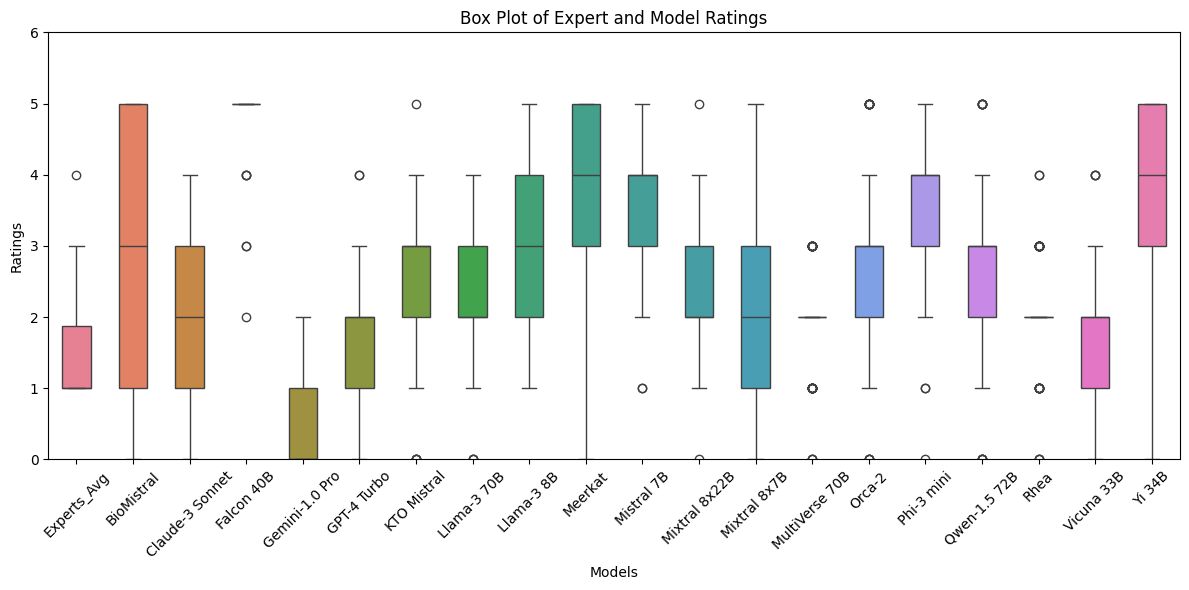

In [14]:
create_plot('boxplot', data=groupA_df[['Experts_Avg'] + model_names],
            figsize=(12, 6), ylim=(0, 6),
            xlabel='Models', ylabel='Ratings',
            title='Box Plot of Expert and Model Ratings',
            xticks_rotation=45)

Expert-Models Inter-Rater Agreement

Model,Weighted Kappa,Kendall's Tau,Spearman's Rho,Brennan-Prediger Kappa,Gwet's AC2
BioMistral,0.03,0.07,0.09,0.04,0.33
Claude-3 Sonnet,0.18,0.26,0.29,0.72,0.82
Falcon 40B,0.01,0.18,0.18,-1.26,-0.24
Gemini-1.0 Pro,-0.01,-0.02,-0.02,0.73,0.85
GPT-4 Turbo,0.30,0.33,0.37,0.82,0.89
KTO Mistral,0.18,0.34,0.39,0.58,0.73
Llama-3 70B,0.17,0.37,0.40,0.71,0.82
Llama-3 8B,0.13,0.41,0.47,0.29,0.47
Meerkat,0.05,0.22,0.25,-0.20,0.07
Mistral 7B,0.08,0.40,0.45,0.10,0.30


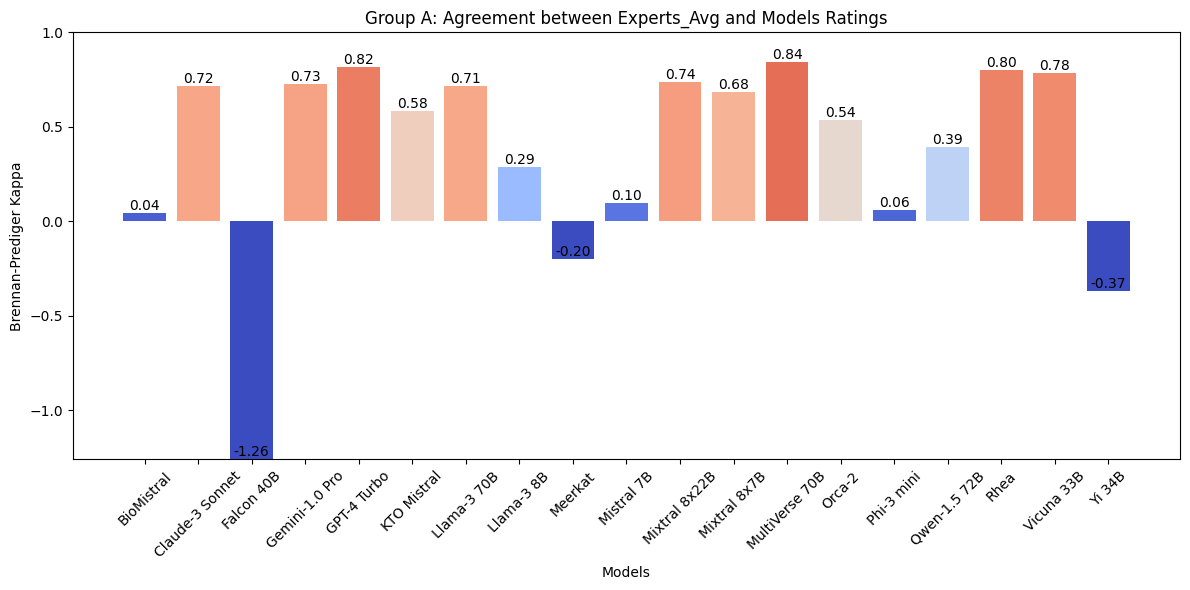

In [15]:
rater1_columns = ['Experts_Avg'] * len(model_names)

stat_groupA_df = plot_agreement_barplot(groupA_df, rater1_columns, model_names, 
                                        'Experts_Avg', 'Models',
                                        categories, agreement_coef, weights_type,
                                        topic_name=topic_name,
                                        xlabel='Models', figsize=(12,6))

stat_groupA_df = stat_groupA_df.T.rename_axis('Model', axis=1)
stat_groupA_df.round(2)

Models Inter-Rater Agreement

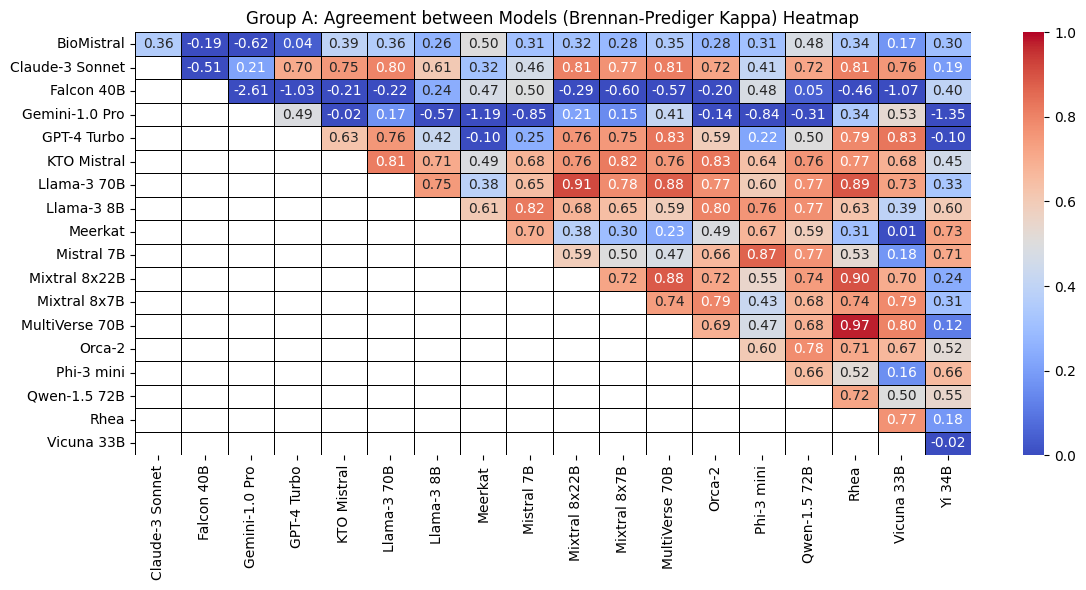

In [16]:
models_agreementA_df = plot_models_agreement_heatmap(groupA_df, model_names, 
                                                     categories, agreement_coef, weights_type,
                                                     topic_name='Group A', figsize=(12,6))

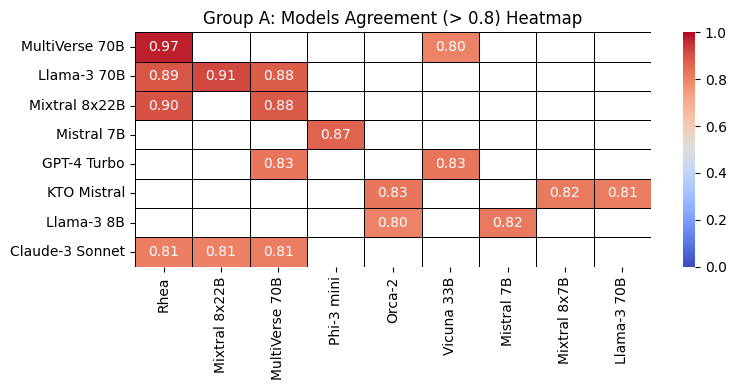

In [19]:
model_agreements_gt_x_percent(models_agreementA_df, 0.8, topic_name, figsize=(8, 4))

### Total Score Analysis
Total scores out of 75.

In [10]:
topic_name = 'Total Rating'
categories = list(range(15,76))
agreement_coef = 'Brennan-Prediger Kappa'
weights_type = 'quadratic'

Experts Agreement

In [11]:
agreement_expert1_vs_expert2 = calculate_statistics(groupB_df, 'Expert1', 'Expert2', categories, weights_type)
print(f'Agreement between Expert 1 and Expert 2:')
pd.DataFrame.from_dict(agreement_expert1_vs_expert2, orient='index', columns=['Value']).round(2)

Agreement between Expert 1 and Expert 2:


,Value
Weighted Kappa,0.88
Kendall's Tau,0.80
Spearman's Rho,0.93
Brennan-Prediger Kappa,0.96
Gwet's AC2,0.97


Distribution of Experts Ratings

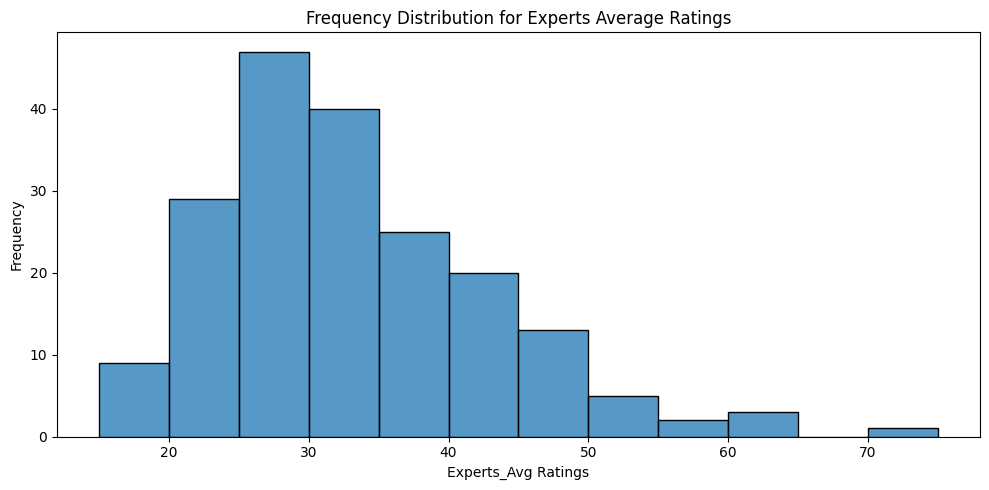

In [20]:
bins = list(range(15,80,5))
create_plot('histplot', groupB_df, x='Experts_Avg', bins=bins,
            xlabel='Experts_Avg Ratings', ylabel='Frequency',
            title='Frequency Distribution for Experts Average Ratings',
            figsize=(10,5))

#### Descriptive Statistics

In [13]:
statB_df = groupB_df.copy().describe().round(2).T
statB_df.rename_axis('Model', axis=1, inplace=True)

rows_to_keep = ['Experts_Avg'] + model_names
statB_df = statB_df[statB_df.index.isin(rows_to_keep)]
statB_df

Model,count,mean,std,min,25%,50%,75%,max
Experts_Avg,194.0,32.80,9.82,18.0,26.00,31.0,39.00,72.0
BioMistral,194.0,52.65,11.17,19.0,45.00,52.0,59.75,75.0
Claude-3 Sonnet,194.0,49.13,9.73,20.0,44.00,49.0,55.00,72.0
Falcon 40B,194.0,59.86,8.72,15.0,60.00,60.0,60.00,75.0
Gemini-1.0 Pro,194.0,37.02,8.45,16.0,32.00,38.0,44.00,63.0
GPT-4 Turbo,194.0,44.31,8.20,20.0,39.00,44.5,50.00,63.0
KTO Mistral,194.0,52.05,14.80,15.0,43.00,54.5,62.00,75.0
Llama-3 70B,194.0,45.98,7.66,25.0,42.00,47.0,51.00,62.0
Llama-3 8B,194.0,48.30,9.26,21.0,42.25,50.0,56.00,64.0
Meerkat,194.0,66.26,11.12,19.0,63.25,71.0,75.00,75.0


Box Plot

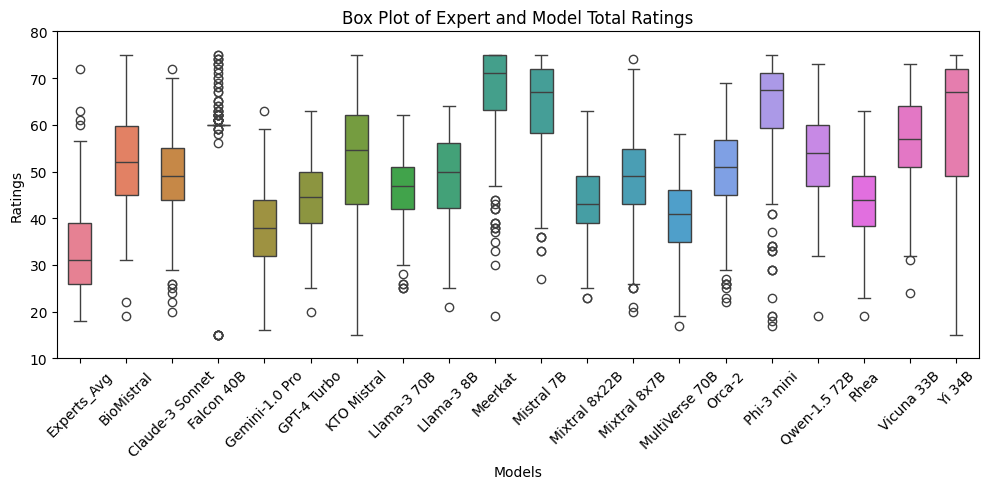

In [14]:
create_plot('boxplot', data=groupB_df[['Experts_Avg'] + model_names],
            figsize=(10, 5), ylim=(10, 80),
            xlabel='Models', ylabel='Ratings',
            title='Box Plot of Expert and Model Total Ratings',
            xticks_rotation=45)

Expert-Models Inter-Rater Agreement

Model,Weighted Kappa,Kendall's Tau,Spearman's Rho,Brennan-Prediger Kappa,Gwet's AC2
BioMistral,0.02,0.03,0.05,0.13,0.15
Claude-3 Sonnet,0.16,0.26,0.36,0.44,0.46
Falcon 40B,-0.01,-0.02,-0.03,-0.46,0.21
Gemini-1.0 Pro,0.40,0.30,0.42,0.84,0.85
GPT-4 Turbo,0.25,0.31,0.44,0.66,0.68
KTO Mistral,0.17,0.27,0.39,0.15,0.17
Llama-3 70B,0.21,0.32,0.45,0.59,0.62
Llama-3 8B,0.20,0.31,0.44,0.46,0.48
Meerkat,0.03,0.11,0.15,-1.02,-0.71
Mistral 7B,0.07,0.28,0.39,-0.70,-0.62


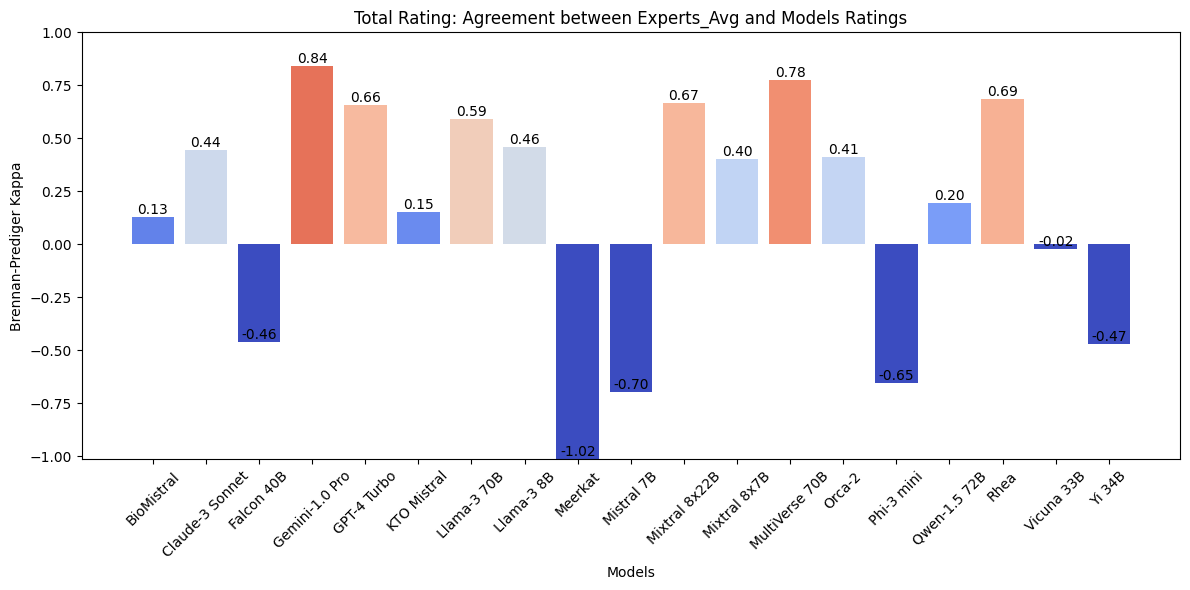

In [15]:
rater1_columns = ['Experts_Avg'] * len(model_names)

stat_groupB_df = plot_agreement_barplot(groupB_df, rater1_columns, model_names, 
                                        'Experts_Avg', 'Models',
                                        categories, agreement_coef, weights_type,
                                        topic_name=topic_name,
                                        xlabel='Models', figsize=(12,6))

stat_groupB_df = stat_groupB_df.T.rename_axis('Model', axis=1)
stat_groupB_df.round(2)

Models Inter-Rater Agreement

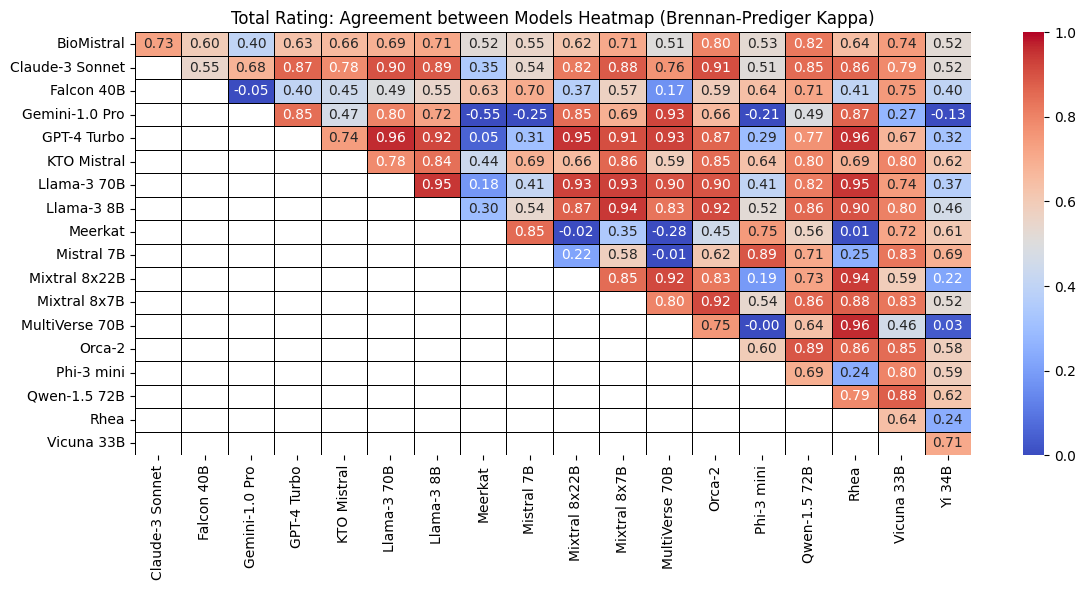

In [21]:
models_agreementB_df = plot_models_agreement_heatmap(groupB_df, model_names, 
                                                     categories, agreement_coef, weights_type,
                                                     topic_name, figsize=(12,6))

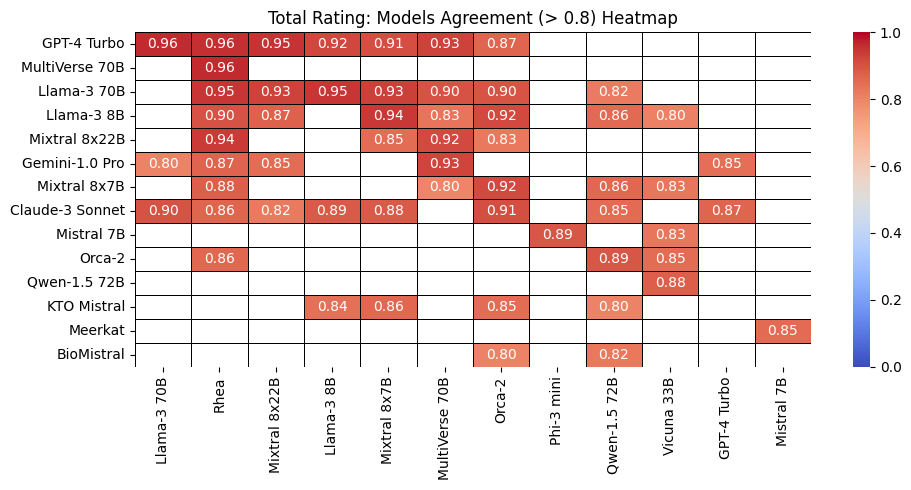

In [28]:
model_agreements_gt_x_percent(models_agreementB_df, 0.8, topic_name, figsize=(10, 5))

### Question-Wise Analysis
Individual 15 scores

In [22]:
topic_name = 'Question-Wise'
categories = list(range(1,6))

Experts Inter-Rater Agreement

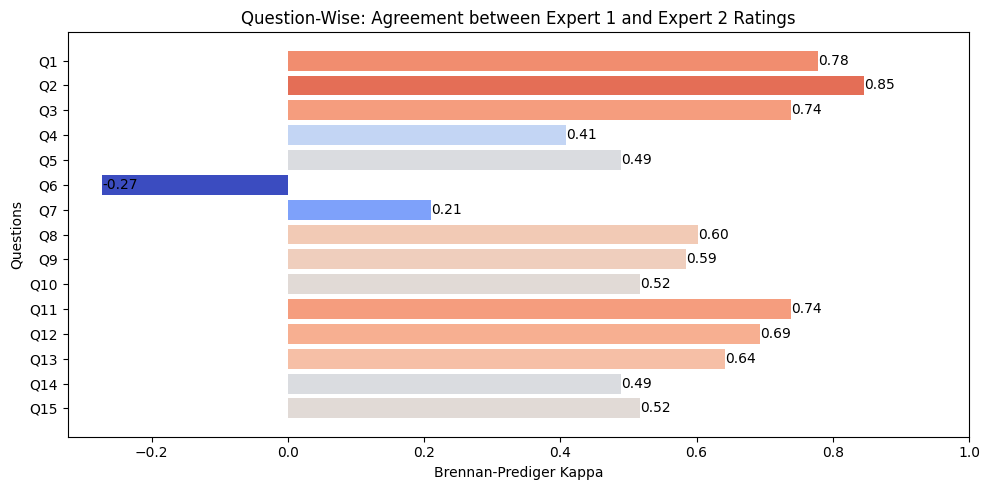

In [34]:
_ = plot_agreement_barplot(groupB_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS,
                           'Expert 1', 'Expert 2',
                           categories, agreement_coef, weights_type, orientation='horizontal',
                           ylabel='Questions', ticklabels=MODEL_15_SCORE_COLUMNS,
                           topic_name=topic_name, figsize=(10,5))

Expert-Model Inter-Rater Agreement

In [23]:
stat_groupC_df = pd.DataFrame(index=MODEL_15_SCORE_COLUMNS, columns=model_names, dtype=float)

for model_name in model_names:
    for question_num in range(1, 16):
        expert_col = f'Experts_Avg Q{question_num}'
        model_col = f'{model_name} Q{question_num}'
        statistics = calculate_statistics(groupB_df, expert_col, model_col, categories, weights_type)
        stat_groupC_df.at[f'Q{question_num}', model_name] = round(statistics.get(agreement_coef), 2)

# stat_groupC_df['Question Average'] = question_avg
# stat_groupC_df.loc['Model Average'] = model_avg

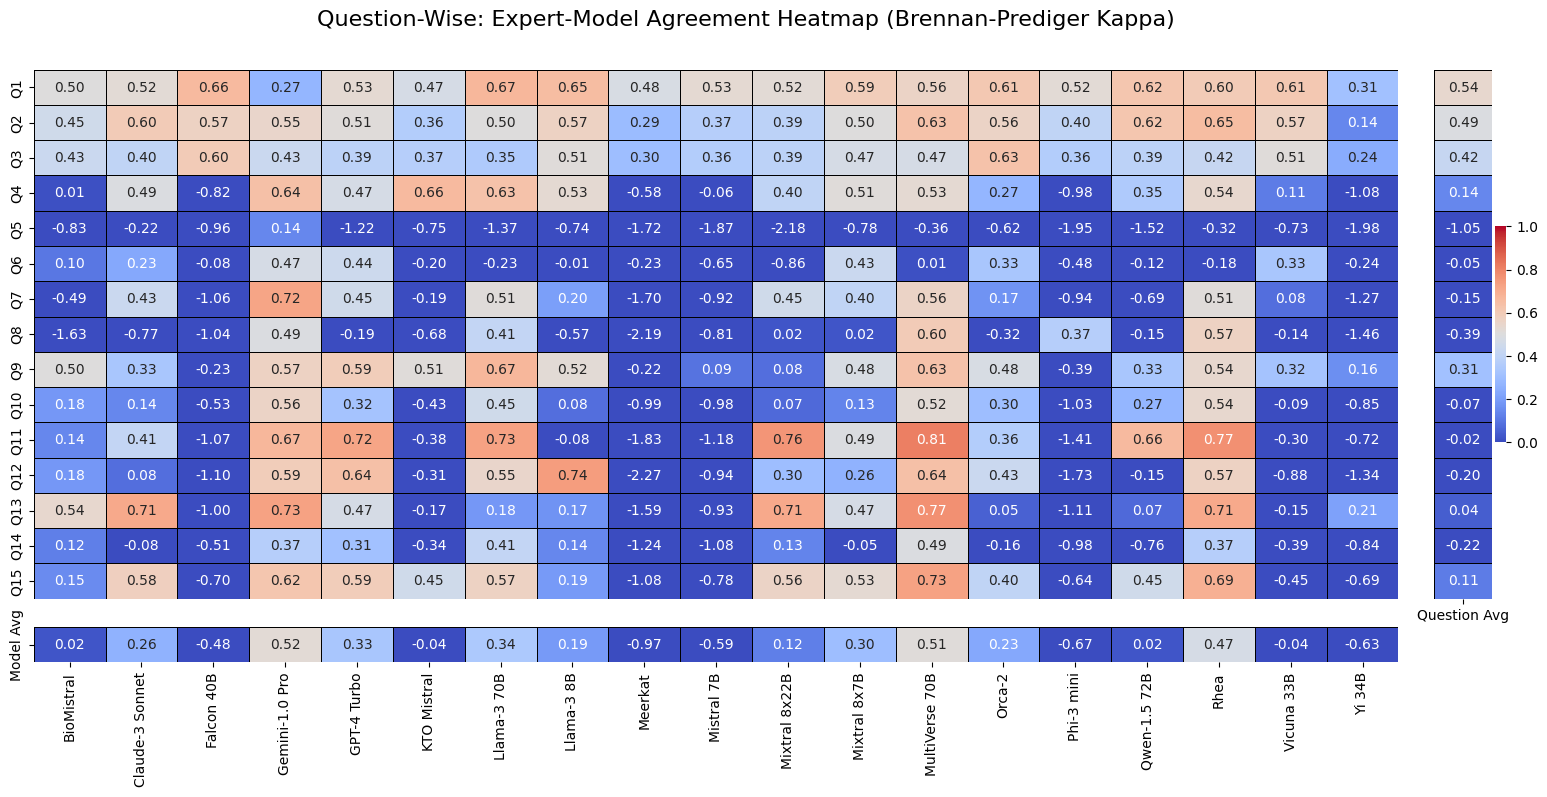

In [24]:
plot_questionwise_agreement_heatmap(stat_groupC_df, agreement_coef, topic_name)#, figsize=(14,6))

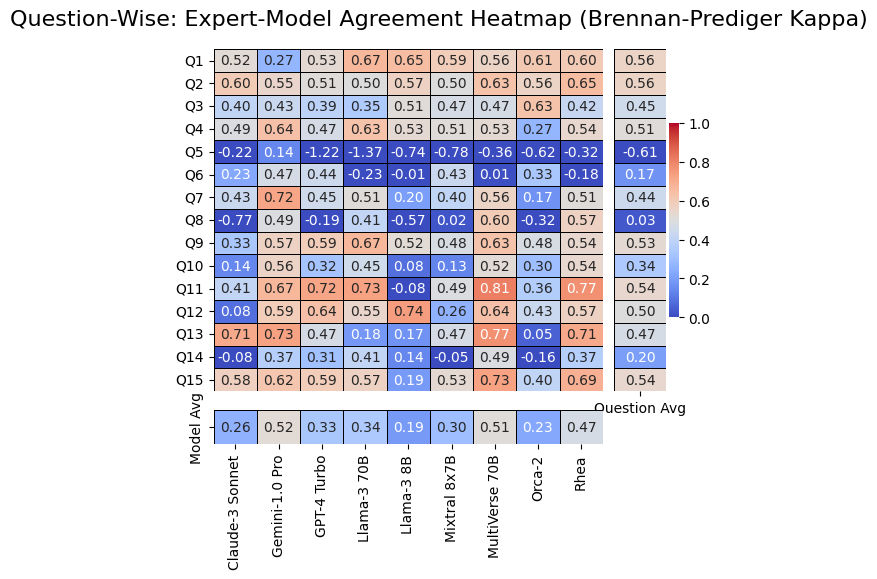

In [31]:
stat_groupC_filtered_df = stat_groupC_df.drop(
    columns=['BioMistral', 'Falcon 40B', 'KTO Mistral', 'Meerkat', 'Mistral 7B', 
             'Mixtral 8x22B', 'Phi-3 mini', 'Qwen-1.5 72B', 'Vicuna 33B', 'Yi 34B', ],
)

plot_questionwise_agreement_heatmap(stat_groupC_filtered_df, agreement_coef, topic_name, figsize=(10,6))

Removing distant ratings between Expert 1 and Expert 2

In [25]:
cleaned_experts_groupB_df, num_of_distant_ratings_per_q = remove_distant_ratings(
    groupB_df, MODEL_15_SCORE_COLUMNS, EXPERT1_COLUMNS, EXPERT2_COLUMNS, max_diff=1
)

Q1: Length of videos with distant ratings: 6
Q2: Length of videos with distant ratings: 2
Q3: Length of videos with distant ratings: 8
Q4: Length of videos with distant ratings: 12
Q5: Length of videos with distant ratings: 8
Q6: Length of videos with distant ratings: 20
Q7: Length of videos with distant ratings: 15
Q8: Length of videos with distant ratings: 8
Q9: Length of videos with distant ratings: 14
Q10: Length of videos with distant ratings: 12
Q11: Length of videos with distant ratings: 8
Q12: Length of videos with distant ratings: 8
Q13: Length of videos with distant ratings: 10
Q14: Length of videos with distant ratings: 9
Q15: Length of videos with distant ratings: 13


Experts Inter-Rater Agreement

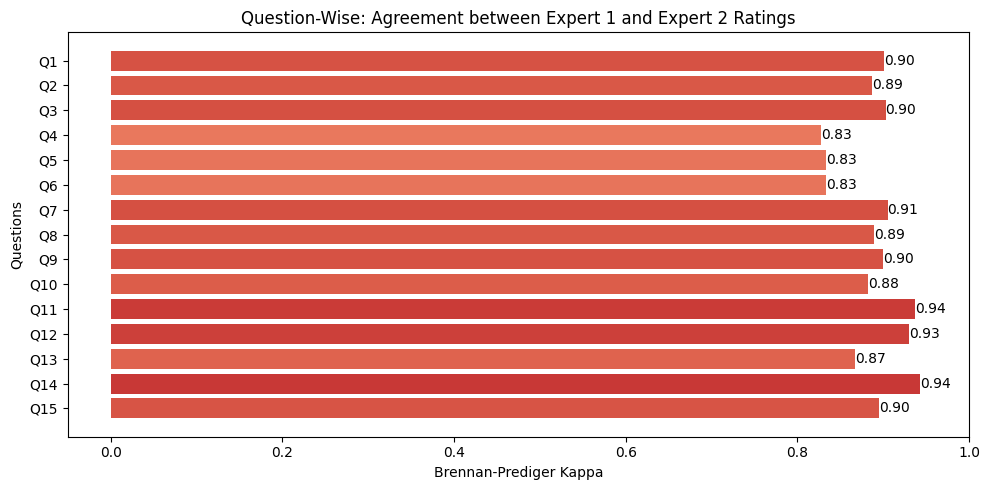

In [26]:
_ = plot_agreement_barplot(cleaned_experts_groupB_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS,
                           'Expert 1', 'Expert 2',
                           categories, agreement_coef, weights_type, orientation='horizontal',
                           ylabel='Questions', ticklabels=MODEL_15_SCORE_COLUMNS,
                           topic_name=topic_name, figsize=(10,5))

Expert-Model Inter-Rater Agreement

In [27]:
stat_cleaned_groupC_df = pd.DataFrame(index=MODEL_15_SCORE_COLUMNS, columns=model_names, dtype=float)

for model_name in model_names:
    for question_num in range(1, 16):
        expert_col = f'Experts_Avg Q{question_num}'
        model_col = f'{model_name} Q{question_num}'
        statistics = calculate_statistics(cleaned_experts_groupB_df, expert_col, model_col, categories, weights_type)
        stat_cleaned_groupC_df.at[f'Q{question_num}', model_name] = round(statistics.get(agreement_coef), 2)

# stat_groupC_df['Question Average'] = question_avg
# stat_groupC_df.loc['Model Average'] = model_avg

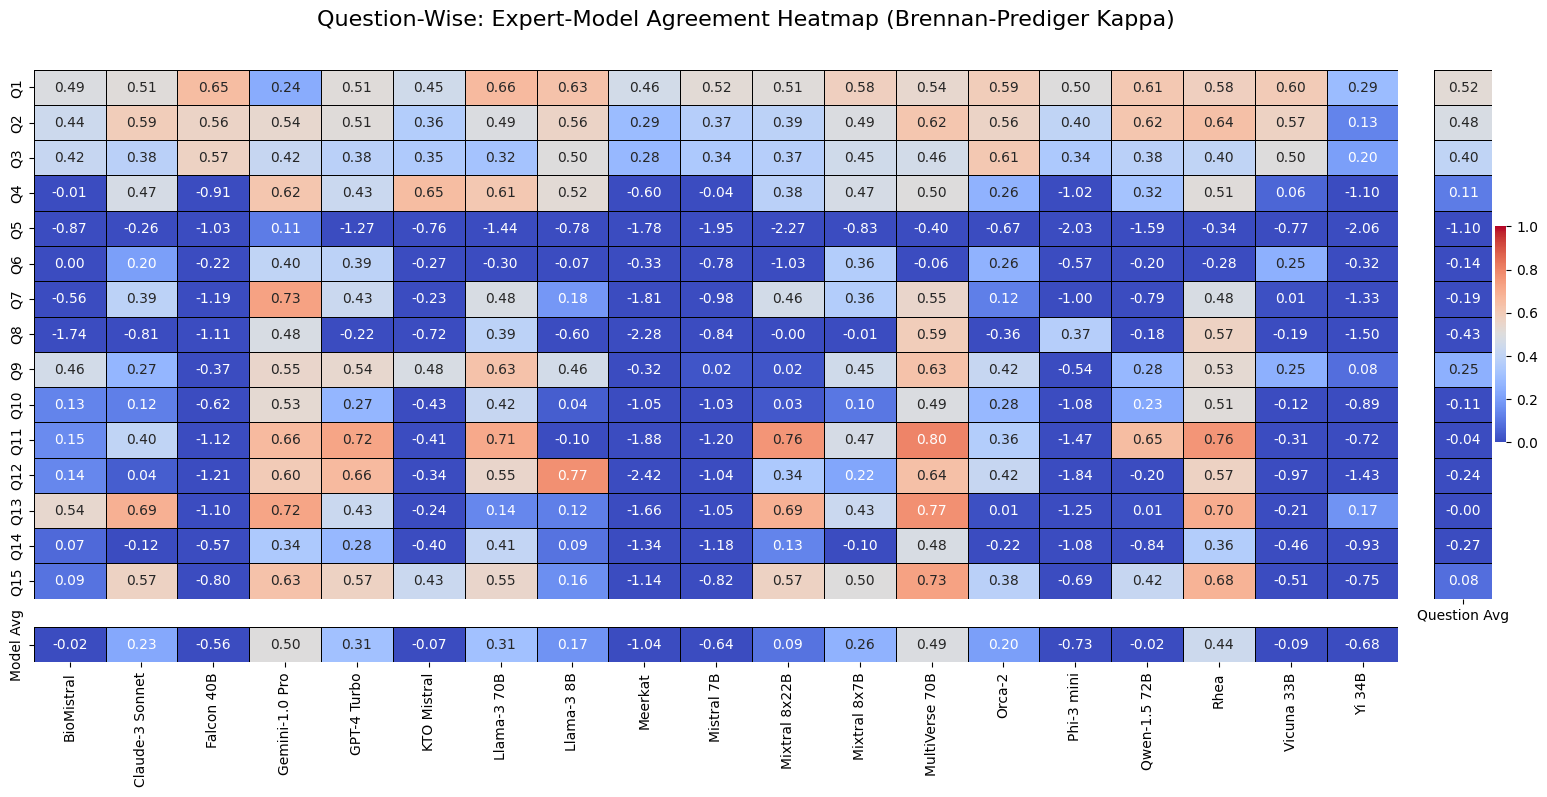

In [28]:
plot_questionwise_agreement_heatmap(stat_cleaned_groupC_df, agreement_coef, topic_name)#, figsize=(14,6))

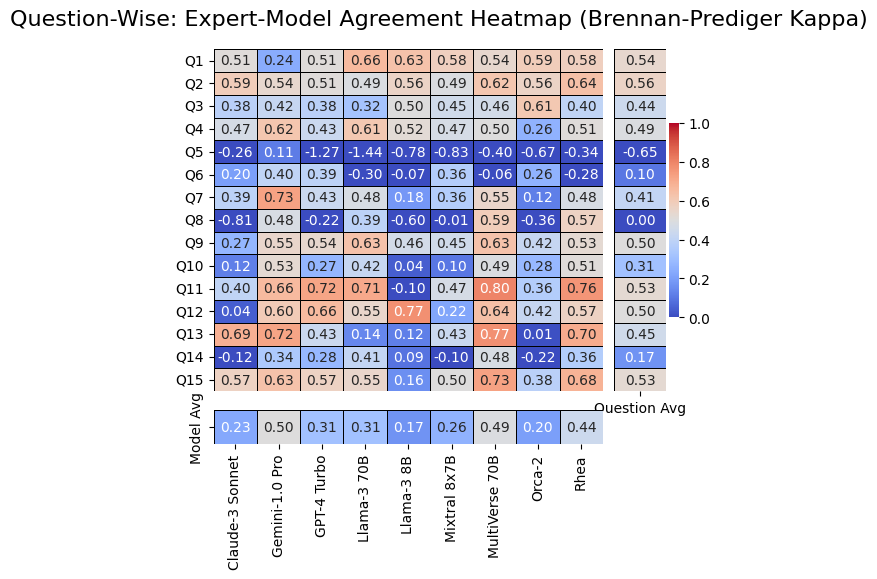

In [30]:
stat_cleaned_groupC_filtered_df = stat_cleaned_groupC_df.drop(
    columns=['BioMistral', 'Falcon 40B', 'KTO Mistral', 'Meerkat', 'Mistral 7B', 
             'Mixtral 8x22B', 'Phi-3 mini', 'Qwen-1.5 72B', 'Vicuna 33B', 'Yi 34B',
             ],
)

plot_questionwise_agreement_heatmap(stat_cleaned_groupC_filtered_df, agreement_coef, topic_name, figsize=(10,6))

### Displaying samples of responses by LLMs

In [141]:
model_file = '../../../Results/LLMs_Responses/gemini-1.0-pro-latest-response.csv'
model_responses_df = pd.read_csv(model_file, encoding='utf-8')

model_responses_df = merge_dataframes(model_responses_df, cleaned_experts_groupB_df, ['Video ID'] + [f'Experts_Avg Q{i}' for i in range(1,16)])

model_responses_df.head(2)

,Video ID,Transcript,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Experts_Avg Q6,Experts_Avg Q7,Experts_Avg Q8,Experts_Avg Q9,Experts_Avg Q10,Experts_Avg Q11,Experts_Avg Q12,Experts_Avg Q13,Experts_Avg Q14,Experts_Avg Q15
0,t6PP67AsJaI,Fetal surgery for spina bifida is an incredibl...,3.0,3.0,3.0,1.0,3.0,3.0,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TuLAGDTpR6Y,My name is Robin Bowman. I'm the director of L...,5.0,5.0,5.0,3.0,5.0,3.0,3.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
diff = 4    # 0 for high agreement, 2 for medium, and 4 for low
q_num = 14

# Filter rows where the difference between Q6 and Experts_Avg Q6 is 'diff'
filtered_df = model_responses_df[model_responses_df[f'Q{q_num}'] - model_responses_df[f'Experts_Avg Q{q_num}'] == diff]

# Display one example of Response_6 where the difference is diff
if not filtered_df.empty:
    example_row = filtered_df.iloc[0]
    response = example_row[f'Response_{q_num}']
    q_score = example_row[f'Q{q_num}']
    avg_score = example_row[f'Experts_Avg Q{q_num}']
    print(example_row['Video ID'])
    print(f'Example Response_{q_num} where Q{q_num}={q_score} and Experts_Avg Q{q_num}={avg_score} have a difference of {diff}:\n{response}')
else:
    print(f'No examples found where Q{q_num} and Experts_Avg Q{q_num} have a difference of {diff}.')

bSeYYXlH1MQ
Example Response_14 where Q14=5.0 and Experts_Avg Q14=1.0 have a difference of 4:
5. The video clearly states that there are multiple possible treatment choices for cluster headaches, including nerve blocks, botox, surgery, and nasal application of capsaicin.
